# Bubble Seep Target Strength Profiles - GISR G08 Research Cruise

This notebook calculates target strength (TS) profiles for bubble seeps at 30 kHz as a function of depth using oceanographic data from MATLAB files and the Medwin-Clay acoustic scattering model.

## Dataset Background

**Research Context:**
- **Research Cruise:** GISR G08 (2015)
- **Location:** Seep site MC118 (Gulf of Mexico)
- **Simulation Model:** TAMOC (Texas A&M Oil spill Calculator)

**Data Sources:**
- **Sonar Data:** Multi-beam echosounder EM302 (shipboard data)
- **Environmental Data:** CTD measurements (temperature and salinity profiles)
- **Bubble Size Distribution:** TAMOC simulation validated with high-speed imaging observations

**References:**
- Wang, B., S. A. Socolofsky, J. A. Breier, and J. S. Seewald (2016), Observations of bubbles in natural seep flares at MC 118 and GC 600 using in situ quantitative imaging, J. Geophys. Res. Oceans, 121, 2203–2230, doi:10.1002/2015JC011452.
- Wang, B., Jun, I., Socolofsky, S. A., DiMarco, S. F., & Kessler, J. D. (2020). Dynamics of gas bubbles from a submarine hydrocarbon seep within the hydrate stability zone. Geophysical Research Letters, 47, e2020GL089256. https://doi.org/10.1029/2020GL089256

## Overview
- Load environmental data (temperature/salinity profiles) from `G08_H1407_041520115.mat`
- Extract bubble size distributions at 51 depth locations from seafloor to the water column where bubble are mostly dissolved
- Calculate TS for each bubble using interpolated T/S conditions
- Aggregate individual bubble backscatter to compute total seep TS
- Compare model predictions with EM302 observations

## Import Required Libraries

Import necessary libraries including scipy.io for MATLAB file reading, numpy for numerical operations, matplotlib for plotting, and scipy.interpolate for interpolation functions.

In [17]:
# Standard scientific computing imports
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# MATLAB file handling
import scipy.io as sio
from scipy.interpolate import interp1d

# Add project root to path for imports
PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

# Import SeaEcho modules
from utils.SeaEcho_water import seawater
from utils.SeaEcho_gas_bubble import air_bubble
from Bubble.models.medwin_clay_model import calculate_medwin_clay_ts

# Set up plotting parameters
plt.rcParams['figure.figsize'] = (12,4)
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2

print("✓ All required modules imported successfully")

✓ All required modules imported successfully


## Load and Explore MATLAB Data

Load the G08_H1407_041520115.mat file and explore the structure of the data including PROFC, PROFC_depth, PROFT, PROFT_depth, and Depth variables.

In [18]:
# Load MATLAB data file
mat_file_path = PROJECT_ROOT / 'validation' / 'G08_H1407_04152015.mat'
print(f"Loading MATLAB data from: {mat_file_path}")

mat_data = sio.loadmat(mat_file_path)
print("✓ MATLAB file loaded successfully")

# Explore the structure of the loaded data
print("\nData structure overview:")
for key in mat_data.keys():
    if not key.startswith('__'):
        data_shape = np.array(mat_data[key]).shape
        data_type = type(mat_data[key])


# Extract key variables
PROFC = np.array(mat_data['PROFC']).flatten()  # Salinity profile
PROFC_depth = np.array(mat_data['PROFC_depth']).flatten()  # Corresponding depths
PROFT = np.array(mat_data['PROFT']).flatten()  # Temperature profile  
PROFT_depth = np.array(mat_data['PROFT_depth']).flatten()  # Corresponding depths
Depth = mat_data['Depth']  # Structure array with bubble data
EM302_profile = np.array(mat_data['EM302_profile']).flatten()  # EM302 sonar data
zp = np.array(mat_data['zp']).flatten()  # Height above seafloor for EM302 data

Loading MATLAB data from: /Users/wangbinb/Library/CloudStorage/OneDrive-UniversityofMissouri/Documents/GitHub/seaEchoTSCalculator/validation/G08_H1407_04152015.mat
✓ MATLAB file loaded successfully

Data structure overview:


## Extract Environmental Profiles

Extract salinity (PROFC) and temperature (PROFT) profiles with their corresponding depth arrays, and create interpolation functions for both parameters.

In [19]:
# Create interpolation functions for temperature and salinity profiles
print("Creating interpolation functions for environmental profiles...")

# Remove any NaN values and sort by depth for interpolation
valid_sal_idx = ~np.isnan(PROFC) & ~np.isnan(PROFC_depth)
valid_temp_idx = ~np.isnan(PROFT) & ~np.isnan(PROFT_depth)

sal_depths_clean = PROFC_depth[valid_sal_idx]
sal_values_clean = PROFC[valid_sal_idx]

temp_depths_clean = PROFT_depth[valid_temp_idx]
temp_values_clean = PROFT[valid_temp_idx]

# Sort by depth
sal_sort_idx = np.argsort(sal_depths_clean)
temp_sort_idx = np.argsort(temp_depths_clean)

sal_depths_sorted = sal_depths_clean[sal_sort_idx]
sal_values_sorted = sal_values_clean[sal_sort_idx]

temp_depths_sorted = temp_depths_clean[temp_sort_idx]
temp_values_sorted = temp_values_clean[temp_sort_idx]

# Create interpolation functions
salinity_interp = interp1d(sal_depths_sorted, sal_values_sorted, 
                          kind='linear', bounds_error=False, fill_value='extrapolate')
temperature_interp = interp1d(temp_depths_sorted, temp_values_sorted, 
                             kind='linear', bounds_error=False, fill_value='extrapolate')



# Test interpolation at a few depths
test_depths = [10, 50, 100]

for depth in test_depths:
    sal = salinity_interp(depth)
    temp = temperature_interp(depth)


Creating interpolation functions for environmental profiles...


## Define Analysis Parameters

Set up the three target frequencies and extract depth locations from the bubble data structure.

In [20]:
# Analysis parameters
frequencies = [30.0]  # Only 30 kHz
WATER_DEPTH = 890.0  # Total water depth in meters
n_depths = Depth.shape[1]  # Number of depth locations

# Setup coordinate system conversion
print(f"Coordinate system setup:")
print(f"  Water depth: {WATER_DEPTH} m")
print(f"  Original: height above seafloor → depth below surface")

# Convert depth coordinates from height above seafloor to depth below surface
depth_locations = np.zeros(n_depths)

for depth_idx in range(n_depths):
    try:
        # Get height above seafloor from z coordinate array
        z_array = Depth[0, depth_idx]['z']
        
        # Convert to numpy array if needed and flatten
        z_array = np.array(z_array).flatten()
        
        # Remove NaN values
        valid_z = z_array[~np.isnan(z_array)]
        
        if len(valid_z) > 0:
            # Take the average of valid z values
            height_above_seafloor = np.mean(valid_z)
            
            # Convert to depth below surface
            depth_below_surface = WATER_DEPTH - height_above_seafloor
            depth_locations[depth_idx] = depth_below_surface
        else:
            # No valid z values found
            depth_locations[depth_idx] = np.nan
            
    except Exception as e:
        # If any error occurs, set to NaN and continue
        depth_locations[depth_idx] = np.nan
        
print(f"Depth coordinate conversion completed:")
valid_depth_coords = depth_locations[~np.isnan(depth_locations)]
print(f"  Valid depth coordinates: {len(valid_depth_coords)}/{n_depths}")
if len(valid_depth_coords) > 0:
    print(f"  Depth range (below surface): {valid_depth_coords.min():.1f} to {valid_depth_coords.max():.1f} m")

# Temperature and salinity interpolation functions
temperature_interp = interp1d(temp_depths_sorted, temp_values_sorted, 
                             kind='linear', bounds_error=False, fill_value='extrapolate')
salinity_interp = interp1d(sal_depths_sorted, sal_values_sorted, 
                          kind='linear', bounds_error=False, fill_value='extrapolate')


Coordinate system setup:
  Water depth: 890.0 m
  Original: height above seafloor → depth below surface
Depth coordinate conversion completed:
  Valid depth coordinates: 51/51
  Depth range (below surface): 390.0 to 890.0 m


## Calculate Target Strength Profiles

For each depth location, interpolate temperature and salinity values, then calculate TS for each bubble at the three frequencies using the Medwin-Clay model.

In [21]:
# Initialize arrays to store results  
frequencies = [30.0]  # Only 30 kHz
n_freqs = len(frequencies)
TS_seep = np.zeros((n_depths, n_freqs))  # Final seep TS for each depth and frequency
valid_depths = np.zeros(n_depths, dtype=bool)  # Track which depths have valid data

print("Calculating target strength profiles...")
print(f"Processing {n_depths} depths × {n_freqs} frequencies = {n_depths * n_freqs} combinations")
print(f"Using corrected depth coordinates: depth below surface for T/S interpolation")

# Process each depth location (all 51 positions)
for depth_idx in range(n_depths):
    current_depth_below_surface = depth_locations[depth_idx]
    
    # Skip depth locations that still have NaN coordinates after correction
    if np.isnan(current_depth_below_surface):
        print(f"  Depth {depth_idx:2d} (NaN m): Skipping - no valid depth coordinate after correction")
        continue
    
    # Extract bubble diameters at this depth and remove NaN values
    bubble_diameters = Depth[0, depth_idx]['d'].flatten()  # in meters
    
    # Remove NaN bubble diameters
    valid_bubble_mask = ~np.isnan(bubble_diameters)
    valid_diameters = bubble_diameters[valid_bubble_mask]
    
    if len(valid_diameters) == 0:
        print(f"  Depth {depth_idx:2d} ({current_depth_below_surface:6.1f} m): No valid bubbles after NaN removal - skipping")
        continue
    
    # Interpolate environmental conditions at this depth (using depth below surface)
    T_interp = float(temperature_interp(current_depth_below_surface))  # Temperature in °C
    S_interp = float(salinity_interp(current_depth_below_surface))     # Salinity in psu
    
    valid_depths[depth_idx] = True
    
    # Create seawater object for this depth/conditions
    # Note: seawater depth parameter expects depth below surface
    water = seawater(T_interp, current_depth_below_surface, S_interp)
    c = water.sound_speed()  # Sound speed at this depth
    
    # Calculate TS for each frequency at this depth
    for freq_idx, freq_khz in enumerate(frequencies):
        # Initialize total backscatter cross section
        sigma_total = 0.0
        successful_bubbles = 0
        
        # Calculate TS for each valid bubble at this frequency
        for diameter in valid_diameters:
            try:
                # Create bubble object (depth parameter is depth below surface)
                bubble = air_bubble(water, T_interp, current_depth_below_surface, S_interp, diameter)
                
                # Calculate TS using Medwin-Clay model
                TS_bubble = calculate_medwin_clay_ts(freq_khz, c, water, bubble)
                
                # Convert TS to backscatter cross section: sigma = 10^(TS/10)
                sigma_bubble = 10**(TS_bubble / 10.0)
                sigma_total += sigma_bubble
                successful_bubbles += 1
                
            except Exception as e:
                # Skip this bubble if calculation fails
                pass
        
        # Convert total backscatter back to TS: TS_seep = 10*log10(sigma_total)
        if sigma_total > 0:
            TS_seep[depth_idx, freq_idx] = 10.0 * np.log10(sigma_total)
        else:
            TS_seep[depth_idx, freq_idx] = np.nan
    
    # Progress indicator
    if depth_idx % 5 == 0 or depth_idx == n_depths - 1:
        progress = (depth_idx + 1) / n_depths * 100
        print(f"  Progress: {progress:5.1f}% - Depth {depth_idx:2d} ({current_depth_below_surface:6.1f} m below surface): "
              f"T={T_interp:5.2f}°C, S={S_interp:5.2f}psu, {len(valid_diameters):3d} valid bubbles")

print(f"✓ Target strength calculations completed")
print(f"  Total depth positions processed: {n_depths}")
print(f"  Valid depths with TS results: {np.sum(valid_depths)}")

# Display summary statistics
print(f"\nTS Summary by frequency:")
for freq_idx, freq_khz in enumerate(frequencies):
    # Only consider depths that have valid coordinates AND TS results
    valid_coord_mask = ~np.isnan(depth_locations)
    valid_ts_mask = valid_depths & ~np.isnan(TS_seep[:, freq_idx])
    
    if np.sum(valid_ts_mask) > 0:
        valid_ts = TS_seep[valid_ts_mask, freq_idx]
        valid_depths_used = depth_locations[valid_ts_mask]
        print(f"  {freq_khz:6.1f} kHz: {len(valid_ts):2d} valid depths, "
              f"TS range: {valid_ts.min():6.1f} to {valid_ts.max():6.1f} dB")
        print(f"    Depth range: {valid_depths_used.min():.1f} to {valid_depths_used.max():.1f} m below surface")
    else:
        print(f"  {freq_khz:6.1f} kHz: No valid data")

Calculating target strength profiles...
Processing 51 depths × 1 frequencies = 51 combinations
Using corrected depth coordinates: depth below surface for T/S interpolation
  Progress:   2.0% - Depth  0 ( 890.0 m below surface): T= 5.48°C, S=34.92psu, 250 valid bubbles
  Progress:  11.8% - Depth  5 ( 840.0 m below surface): T= 5.74°C, S=34.91psu, 244 valid bubbles
  Progress:  21.6% - Depth 10 ( 790.0 m below surface): T= 5.85°C, S=34.91psu, 231 valid bubbles
  Progress:  31.4% - Depth 15 ( 740.0 m below surface): T= 6.07°C, S=34.90psu, 201 valid bubbles
  Progress:  41.2% - Depth 20 ( 690.0 m below surface): T= 6.49°C, S=34.90psu, 159 valid bubbles
  Progress:  51.0% - Depth 25 ( 640.0 m below surface): T= 7.32°C, S=34.93psu, 104 valid bubbles
  Progress:  60.8% - Depth 30 ( 590.0 m below surface): T= 7.72°C, S=34.95psu,  65 valid bubbles
  Progress:  70.6% - Depth 35 ( 540.0 m below surface): T= 8.20°C, S=34.98psu,  43 valid bubbles
  Progress:  80.4% - Depth 40 ( 490.0 m below surfac

## Combined Analysis Figure

Create a three-panel figure showing:
1. Temperature and salinity profiles vs depth (dual x-axis)
2. Median bubble diameter and valid bubble percentage vs depth (dual x-axis)
3. TS profiles (30 kHz model vs filtered experimental data, removing EM302 values < -45 dB)

✓ Combined analysis plot saved to: /Users/wangbinb/Library/CloudStorage/OneDrive-UniversityofMissouri/Documents/GitHub/seaEchoTSCalculator/plots/GISR_G08.pdf


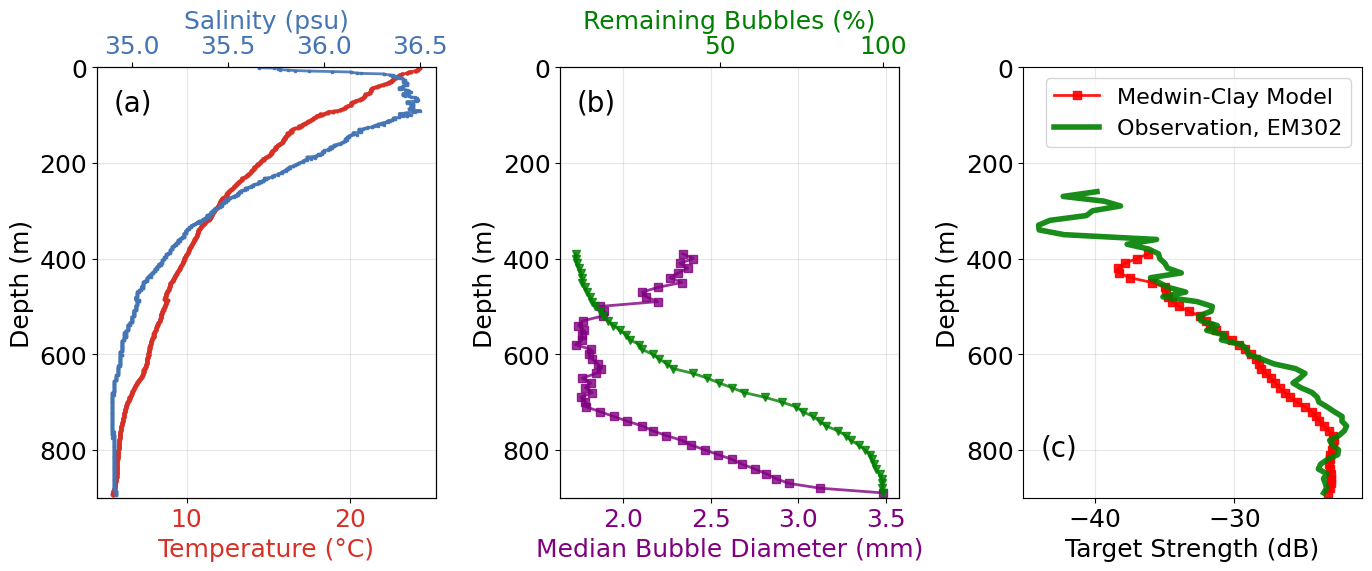

In [22]:
# Calculate median bubble diameter and bubble count percentage at each depth
median_diameters = []
diameter_depths = []
bubble_percentages = []

# Maximum expected bubble count per depth (based on data structure)
MAX_BUBBLES_PER_DEPTH = 250

for depth_idx in range(n_depths):
    current_depth_below_surface = depth_locations[depth_idx]
    
    # Skip depth locations with NaN coordinates
    if np.isnan(current_depth_below_surface):
        continue
    
    # Extract bubble diameters at this depth
    bubble_diameters = Depth[0, depth_idx]['d'].flatten()  # in meters
    
    # Remove NaN bubble diameters
    valid_bubble_mask = ~np.isnan(bubble_diameters)
    valid_diameters = bubble_diameters[valid_bubble_mask]
    
    if len(valid_diameters) > 0:
        # Calculate median diameter and convert to millimeters for plotting
        median_diameter_mm = np.median(valid_diameters) * 1000  # Convert m to mm
        median_diameters.append(median_diameter_mm)
        diameter_depths.append(current_depth_below_surface)
        
        # Calculate percentage of valid bubbles relative to maximum possible (250)
        valid_bubble_percentage = (len(valid_diameters) / MAX_BUBBLES_PER_DEPTH) * 100
        bubble_percentages.append(valid_bubble_percentage)

median_diameters = np.array(median_diameters)
diameter_depths = np.array(diameter_depths)
bubble_percentages = np.array(bubble_percentages)

# Filter EM302 data to remove values below -45 dB
EM302_calibrated = EM302_profile - 8.0
zp_depth = WATER_DEPTH - zp

# Create mask for TS values >= -45 dB
ts_filter_mask = EM302_calibrated >= -45.0
EM302_filtered = EM302_calibrated[ts_filter_mask]
zp_depth_filtered = zp_depth[ts_filter_mask]

# Create combined three-panel figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 6))

# Panel 1: Temperature and Salinity Profiles (dual x-axis)
ax1_temp = ax1
ax1_sal = ax1.twiny()

# Temperature on bottom axis (navy blue)
ax1_temp.plot(temp_values_sorted, temp_depths_sorted, color='#d73027', linestyle='-', linewidth=2, marker='o', markersize=2, alpha=0.9, label='Temperature')
ax1_temp.set_xlabel('Temperature (°C)', fontsize=18, color='#d73027')
ax1_temp.set_ylabel('Depth (m)', fontsize=18)
ax1_temp.tick_params(axis='x', labelcolor='#d73027', labelsize=18)
ax1_temp.tick_params(axis='y', labelsize=18)
ax1_temp.grid(True, alpha=0.3)
ax1_temp.invert_yaxis()
ax1_temp.set_ylim(900, 0)

# Salinity on top axis (teal)
ax1_sal.plot(sal_values_sorted, sal_depths_sorted, color='#4575b4', linestyle='-', linewidth=2, marker='s', markersize=2, alpha=0.9, label='Salinity')
ax1_sal.set_xlabel('Salinity (psu)', fontsize=18, color='#4575b4')
ax1_sal.tick_params(axis='x', labelcolor='#4575b4', labelsize=18)

# Panel 2: Bubble Diameter and Percentage (dual x-axis)
ax2_diameter = ax2
ax2_percentage = ax2.twiny()

# Median Bubble Diameter on bottom axis (purple)
ax2_diameter.plot(median_diameters, diameter_depths, 'purple', linewidth=2, marker='s', markersize=6, alpha=0.8)
ax2_diameter.set_xlabel('Median Bubble Diameter (mm)', fontsize=18, color='purple')
ax2_diameter.set_ylabel('Depth (m)', fontsize=18)
ax2_diameter.tick_params(axis='x', labelcolor='purple', labelsize=18)
ax2_diameter.tick_params(axis='y', labelsize=18)
ax2_diameter.grid(True, alpha=0.3)
ax2_diameter.invert_yaxis()
ax2_diameter.set_ylim(900, 0)

# Valid Bubble Percentage on top axis (orange)
ax2_percentage.plot(bubble_percentages, diameter_depths, 'green', linewidth=2, marker='v', markersize=6, alpha=0.8)
ax2_percentage.set_xlabel('Remaining Bubbles (%)', fontsize=18, color='green')
ax2_percentage.tick_params(axis='x', labelcolor='green', labelsize=18)

# Panel 3: TS Profiles (30 kHz Model + Filtered Experimental data)
freq_khz = 30.0
freq_idx = frequencies.index(freq_khz)

# Extract valid data points for 30 kHz (check if model data exists)
if 'TS_seep' in globals() and TS_seep.size > 0:
    valid_coord_mask = ~np.isnan(depth_locations)
    valid_ts_mask = valid_depths & ~np.isnan(TS_seep[:, freq_idx])
    valid_mask = valid_coord_mask & valid_ts_mask

    if np.sum(valid_mask) > 0:
        depths_plot = depth_locations[valid_mask]
        ts_plot = TS_seep[valid_mask, freq_idx]
        
        ax3.plot(ts_plot, depths_plot, 
                color='red', 
                linestyle='-',
                marker='s',
                markersize=6,
                linewidth=2,
                label=f'Medwin-Clay Model',
                alpha=0.9)

# Add filtered experimental data from EM302_profile with calibration correction
ax3.plot(EM302_filtered, zp_depth_filtered, 
        color='green', 
        linestyle='-',
        linewidth=4,
        label='Observation, EM302',
        alpha=0.9)

ax3.set_xlabel('Target Strength (dB)', fontsize=18)
ax3.set_ylabel('Depth (m)', fontsize=18)
ax3.tick_params(axis='both', labelsize=18)
ax3.grid(True, alpha=0.3)
ax3.legend(fontsize=16, loc='best')
ax3.invert_yaxis()
ax3.set_ylim(900, 0)

# Add panel labels
ax1.text(0.05, 0.95, '(a)', transform=ax1.transAxes, fontsize=20, 
         verticalalignment='top')
ax2.text(0.05, 0.95, '(b)', transform=ax2.transAxes, fontsize=20, 
         verticalalignment='top')
ax3.text(0.05, 0.15, '(c)', transform=ax3.transAxes, fontsize=20, 
         verticalalignment='top')

plt.tight_layout()

# Save the combined plot
combined_plot_file = PROJECT_ROOT / 'plots' / 'GISR_G08.pdf'
plt.savefig(combined_plot_file, bbox_inches='tight')
print(f"✓ Combined analysis plot saved to: {combined_plot_file}")

plt.show()

